How many days do you wish to search? For one year, it's 365:   730
Output File already exists. Deleting...
Creating new file for Bitcoin as png
Output File already exists. Deleting...
Creating new file for Litecoin as png
Output File already exists. Deleting...
Creating new file for Ethereum as png
         Time        Date      bitcoin    litecoin    ethereum
0    00:00:00  2018-05-16  8473.348649  138.829411  703.155681
1    00:00:00  2018-05-17  8343.125222  138.220822  702.453119
2    00:00:00  2018-05-18  8056.053192  131.610957  665.627531
3    00:00:00  2018-05-19  8202.825410  134.695706  686.213269
4    00:00:00  2018-05-20  8180.627010  133.259137  685.846754
..        ...         ...          ...         ...         ...
726  00:00:00  2020-05-11  8752.617088   47.043586  210.431818
727  00:00:00  2020-05-12  8604.751591   42.241799  185.674718
728  00:00:00  2020-05-13  8786.018918   42.100776  189.305782
729  00:00:00  2020-05-14  8786.018918   43.215351  189.305782
730  15

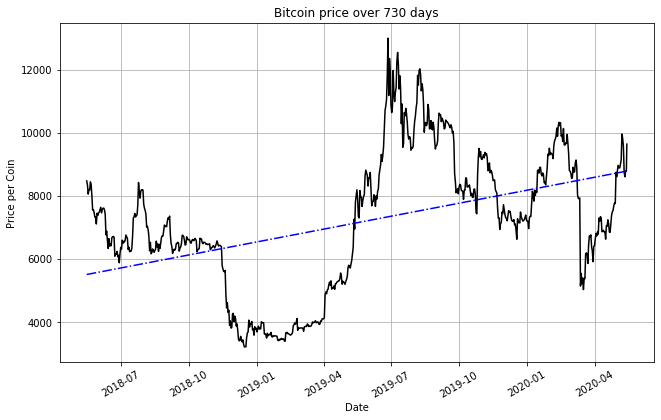

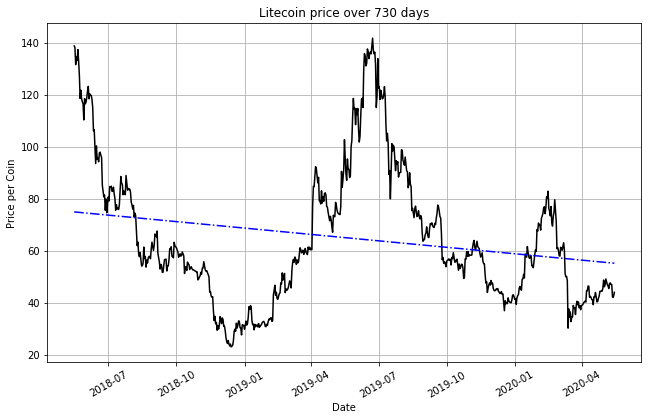

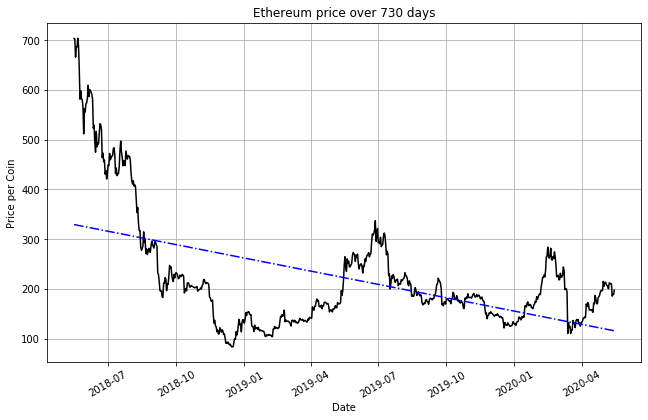

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
import requests, json, datetime, sys, os

def dataFigure(date_time, value, date_time_seconds, time_frame, key):
    plt.figure(figsize=(9,6))
    plt.xticks(rotation = 30)
    plt.grid()
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.plot(date_time, value, color = 'black')
    plt.title(f"{key.capitalize()} price over {time_frame} days")
    plt.xlabel('Date')
    plt.ylabel('Price per Coin')
    regression = []
    (slope, intercept, rvalue, pvalue, stderr) = linregress(date_time_seconds, value)
    regress_values = []
    for unix_translate in date_time_seconds:
        regress_values.append(unix_translate * slope + intercept)
    plt.plot(date_time, regress_values,'-.', color = 'Blue')
    try:
        os.remove(f'{key.capitalize()}.png')
        print('Output File already exists. Deleting...') 
        print(f'Creating new file for {key.capitalize()} as png')
        plt.savefig(f'{key.capitalize()}.png')
    except OSError:
        print(f'Creating save file for {key.capitalize()} as png')
        plt.savefig(f'{key.capitalize()}.png')
        pass
    
def checkCoinPrice(url, key):
    response = requests.get(url)
    data_construct = response.json()
    if data_construct == {"error":"Could not find coin with the given id"} or data_construct == {'error': 'invalid vs_currency'}:
        print("There was an issue with variables. Check work and try again.")
    date_time = []   
    value = []
    date_time_seconds = []    
    for row in data_construct['prices']:
        date_time.append(datetime.datetime.utcfromtimestamp(int(row[0]/1000)))
        value.append(row[1])
        date_time_seconds.append(int((row[0]/1000)))
        
    date = []
    time = []
    for convertline in date_time:
        split = str(convertline).split(' ')
        date.append(split[0])
        time.append(split[1])
    data_frame = pd.DataFrame(date, time)
    data_frame = data_frame.reset_index().rename(columns= {0: 'Date', 'index': 'Time'})
    data_frame[key] = value
    return(date_time, value, date_time_seconds, data_frame)
    
def dataFrameFinal(crypto_frame):
    crypto_frame.columns = map(str.capitalize, crypto_frame.columns)
    sum_of_coins = crypto_frame.describe()
    print(sum_of_coins)
    
    
def main():
    quick_keys = {1: 'bitcoin', 2: 'litecoin', 3: 'ethereum'}
    time_frame = int(input("How many days do you wish to search? For one year, it's 365:   "))
    listOfDicts = None
    for coin_type in range(3):
        key = quick_keys[coin_type + 1]
        url = f'https://api.coingecko.com/api/v3/coins/{key}/market_chart?vs_currency=usd&days={time_frame}'
        date_time, value, date_time_seconds, data_frame = checkCoinPrice(url, key)
        if listOfDicts is None:
            listOfDicts = data_frame
        else:
            listOfDicts[key] = data_frame[key]
        
        dataFigure(date_time, value, date_time_seconds, time_frame, key)
    print(listOfDicts)
    dataFrameFinal(listOfDicts)
    
main()